# Project: CycleGAN
Univ.AI <br>
AI-4 Cohort-2

Name of the people who worked on the project: **Aditya Sreedhar/ Prerna Mahajan/ Chetan Jagadeesh/ Sahil Joshi**

Link to presentation: <br> https://drive.google.com/drive/folders/1dxDdAshg8LuSI-ixzZV_S70QRU3iPUuB?usp=sharing </br>
Link to slides: <br> https://drive.google.com/drive/folders/1dxDdAshg8LuSI-ixzZV_S70QRU3iPUuB?usp=sharing </br>
Link to poster: <br> https://drive.google.com/drive/folders/1dxDdAshg8LuSI-ixzZV_S70QRU3iPUuB?usp=sharing </br>

# Introduction

**Abstract from original publication (Link:https://www.cs.cmu.edu/~junyanz/projects/CycleGAN/CycleGAN.pdf):**

Image-to-image translation is a class of vision and
graphics problems where the goal is to learn the mapping
between an input image and an output image using a training
set of aligned image pairs. However, for many tasks,
paired training data will not be available. We present an
approach for learning to translate an image from a source
domain X to a target domain Y in the absence of paired
examples. Our goal is to learn a mapping G : X --> Y
such that the distribution of images from G(X) is indistinguishable
from the distribution Y using an adversarial loss.
Because this mapping is highly under-constrained, we couple
it with an inverse mapping F : Y --> X and introduce
a cycle consistency loss to push F(G(X)) ~ X (and vice
versa). Qualitative results are presented on several tasks
where paired training data does not exist, including style
transfer, object transfiguration, and season transfer. Quantitative
comparisons against several prior methods demonstrate
the superiority of our approach.

In [1]:
#Import Dependencies
import os, shutil
import json, random
import PIL
import re
import tensorflow as tf
from tensorflow.keras import Model, losses, optimizers
import tensorflow_addons as tfa
import tensorflow.keras.layers as L
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.backend import clear_session

C:\Users\adity\.conda\envs\tf_gpu\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#Initialize TF Variables
clear_session()
strategy = tf.distribute.get_strategy()
AUTO = tf.data.experimental.AUTOTUNE

In [3]:
UKIYO_TRAIN_FILES = r"C:\Users\adity\AI4 Project\ukiyoe2photo\trainA"
UKIYO_TEST_FILES = r"C:\Users\adity\AI4 Project\ukiyoe2photo\testA"
REAL_TRAIN_FILES = r"C:\Users\adity\AI4 Project\ukiyoe2photo\trainB"
REAL_TEST_FILES = r"C:\Users\adity\AI4 Project\ukiyoe2photo\testB"

In [4]:
#Parameters for Image pre-processing and training
EPOCHS = 30
BATCH_SIZE = 1
CHANNELS = 3
HEIGHT = 256
WIDTH = 256

In [5]:
#FUNCTIONS FOR DATASET PRE-PROCESSING
def reshape_image(image):
    image = tf.reshape(image[0], [HEIGHT, WIDTH, CHANNELS])
    image = tf.image.random_flip_left_right(image)
    return image

def load_dataset(directory):
    dataset = tf.keras.utils.image_dataset_from_directory(directory,image_size=(HEIGHT, WIDTH),batch_size=BATCH_SIZE)
    normalization = tf.keras.layers.Rescaling(1./255)
    dataset = dataset.map(lambda x, y: reshape_image(normalization(x)))
    return dataset
def display_sample_images(dataset, row, col):
    ds_iter = iter(dataset)
    plt.figure(figsize=(20, int(20*row/col)))
    for j in range(row*col):
        example_sample = next(ds_iter)
        plt.subplot(row,col,j+1)
        plt.axis('off')
        plt.imshow(example_sample[0].numpy())
    plt.show()

**Taking a look at the data:**

First, we print a few samples of Ukiyo images and Real images from our dataset

Found 562 files belonging to 1 classes.


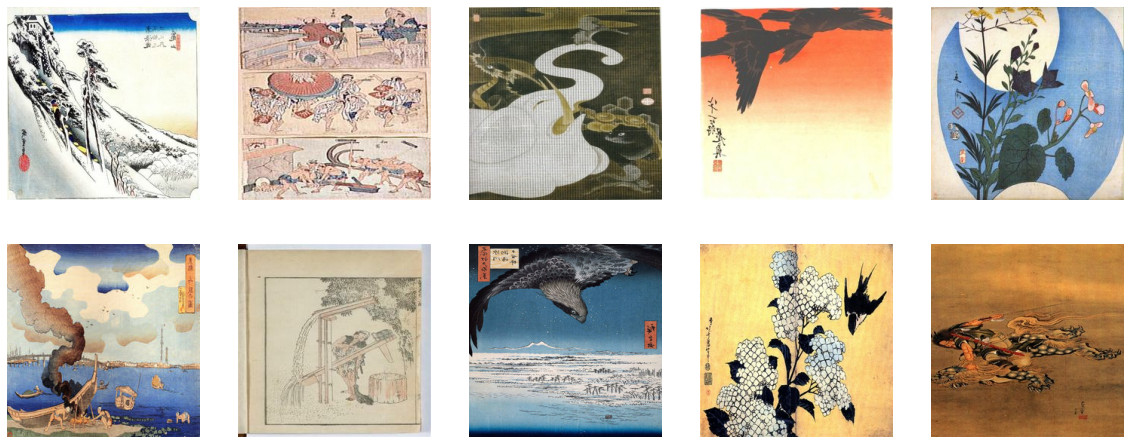

In [6]:
#See a few samples of Ukiyo images
display_sample_images(load_dataset(UKIYO_TRAIN_FILES).batch(1), 2, 5)

Found 6287 files belonging to 1 classes.


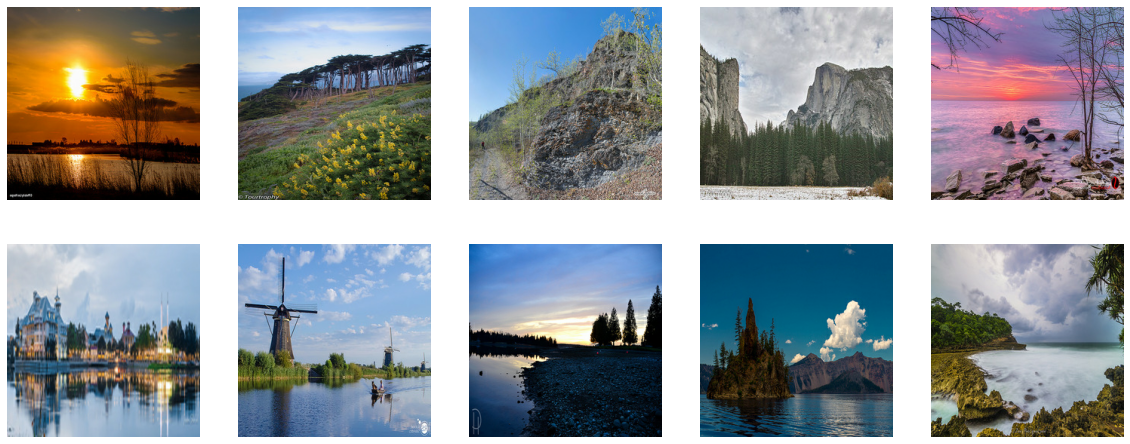

In [7]:
#See a few samples of Real images
display_sample_images(load_dataset(REAL_TRAIN_FILES).batch(1), 2, 5)

In [8]:
#FUNCTION TO GET COMBINED DATASET OF UKIYO AND REAL IMAGES WITH REPEAT, SHUFFLE, PRE-FETCH AND CACHE
def zip_gan_dataset(ukiyo_files, real_files, batch_size=1):

    ukiyo_ds = load_dataset(ukiyo_files)
    real_ds = load_dataset(real_files)


    ukiyo_ds = ukiyo_ds.repeat()
    real_ds = real_ds.repeat()

    ukiyo_ds = ukiyo_ds.shuffle(256)
    real_ds = real_ds.shuffle(256)
        
    ukiyo_ds = ukiyo_ds.batch(batch_size, drop_remainder=True)
    real_ds = real_ds.batch(batch_size, drop_remainder=True)
    
    ukiyo_ds = ukiyo_ds.prefetch(AUTO)
    real_ds = real_ds.prefetch(AUTO)
    
    ukiyo_ds = ukiyo_ds.cache()
    real_ds = real_ds.cache()
    
    gan_dataset = tf.data.Dataset.zip((ukiyo_ds, real_ds))
    
    return gan_dataset

# Model Definition

**Generator Model:**
The Generator Model contains stride-2 convolution blocks, residual layers and fractional-strided
convolutions with stride 1/2 during upsampling. 1/2 Stride is achieved by using Conv2DTranspose layers during upsampling of the images

**Discriminator Model (Link: https://paperswithcode.com/method/patchgan):**
The Discriminator uses a PatchGAN architecture which only penalizes structure at the scale of local image patches. The PatchGAN discriminator tries to classify if each patch in an image is real or fake. This discriminator is run convolutionally across the image, averaging all responses to provide the ultimate output of D. Such a discriminator effectively models the image as a Markov random field, assuming independence between pixels separated by more than a patch diameter. It can be understood as a type of texture/style loss.

Both the Generator and Discriminator use LeakyRELU activation and Instance Normalization. The Instance Normalization layer is referenced from tensorflow_addons (Link: https://www.tensorflow.org/addons/api_docs/python/tfa/layers/InstanceNormalization). We start by defining 2 functions - one for downsampling and one for upsampling, so that they can be further utilized during model definitions for both generator and discriminator

In [9]:
# Model functions
def downsample_layer(filters, size, strides=2,instancenorm=True):

    res = tf.keras.Sequential()
    res.add(L.Conv2D(filters, size, strides=strides, padding='same',
                        kernel_initializer=tf.random_normal_initializer(0., 0.03), use_bias=False)) #Conv Layer
    if instancenorm:
        res.add(tfa.layers.InstanceNormalization(gamma_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.03)))

    res.add(L.LeakyReLU())

    return res

def upsample_layer(filters, size, dropout=False, strides=2):

    res = tf.keras.Sequential()
    res.add(L.Conv2DTranspose(filters, size, strides=strides, padding='same',
                                 kernel_initializer=tf.random_normal_initializer(0., 0.03), use_bias=False))

    res.add(tfa.layers.InstanceNormalization(gamma_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.03)))

    if dropout:
        res.add(L.Dropout(0.5))

    res.add(L.ReLU())

    return res

Next, we define the functions for creating Generators and Discriminators. 2 instances of each will be created and trained

In [10]:
#DEFINE GENERATOR MODEL
CHANNELS = 3

def GENERATOR():
    input_layer = L.Input(shape=[HEIGHT, WIDTH, CHANNELS])

    #Create Downsampling and Upsampling Layers
    downsample_list = [
        downsample_layer(64, 4, instancenorm=False),
        downsample_layer(128, 4),                          
        downsample_layer(256, 4),                          
        downsample_layer(512, 4),                          
        downsample_layer(512, 4),                          
        downsample_layer(512, 4),                          
        downsample_layer(512, 4),                          
        downsample_layer(512, 4),                          
    ]

    upsample_list = [
        upsample_layer(512, 4, dropout=True),
        upsample_layer(512, 4, dropout=True),
        upsample_layer(512, 4, dropout=True),
        upsample_layer(512, 4),                     
        upsample_layer(256, 4),                     
        upsample_layer(128, 4),                     
        upsample_layer(64, 4),                      
    ]

    #Add Last Layer with tanh activation 
    last_layer = L.Conv2DTranspose(CHANNELS, 4,
                             strides=2,
                             padding='same',
                             activation='tanh',
                             kernel_initializer=tf.random_normal_initializer(0., 0.03)
                             )

    x = input_layer

    # Adding Downsampling Layers to skip_layers list
    skip_layers = []
    for down in downsample_list:
        x = down(x)
        skip_layers.append(x)

    skip_layers = reversed(skip_layers[:-1])

    # Adding Upsampling layers and creating skip connections
    for up, skip in zip(upsample_list, skip_layers):
        x = up(x)
        x = L.Concatenate()([x, skip])  #Adding Skip Connections by using Concatenate Layer

    x = last_layer(x)

    return Model(inputs=input_layer, outputs=x)

In [11]:
#DEFINE DISCRIMINATOR MODEL
def DISCRIMINATOR():

    input_layer = L.Input(shape=[HEIGHT, WIDTH, CHANNELS], name='input_layer')

    x = input_layer

    d1 = downsample_layer(64, 4, instancenorm = False)(x)
    d2 = downsample_layer(128, 4)(d1)
    d3 = downsample_layer(256, 4)(d2)

    zpad1 = L.ZeroPadding2D()(d3)
    conv_layer = L.Conv2D(512, 4, strides=1,
                    kernel_initializer=tf.random_normal_initializer(0., 0.02),
                    use_bias=False)(zpad1)

    norm1 = tfa.layers.InstanceNormalization(gamma_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02))(conv_layer)

    leakyrelu = L.LeakyReLU()(norm1)

    zpad2 = L.ZeroPadding2D()(leakyrelu)

    last_layer = L.Conv2D(1, 4, strides=1,
                    kernel_initializer=tf.random_normal_initializer(0., 0.02))(zpad2)

    return Model(inputs=input_layer, outputs=last_layer)

# CycleGAN Class Definition

Now, we define the CycleGAN class which derives from keras Model class. We define a custom train_step function which will take into account the custom loss function defined in the paper.

**Loss Definition:**
The overall loss of the CycleGAN comprises of 3 types of loss
* Adversarial Loss : This is the loss function for the mapping function G : X -> Y and its discriminator
  D(Y) , we express the objective as:  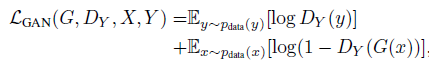
  where G tries to generate images G(x) that look similar
  to images from domain Y , while D(Y) aims to distinguish
  between translated samples G(x) and real samples
  y. There are 2 generators, each of which will have one adversarial loss element.
  
  
  
* Cycle Consistency Loss : To further reduce the space of plausible mapping
  functions, we argue that the learned mapping functions
  should be cycle-consistent. for each image x from domain X, the image translation cycle
  should be able to bring x back to the original image, i.e.
  x -> G(x) -> F(G(x)) -> x. This is called forward cycle consistency.
  For domain Y , G and F should also satisfy the
  backward cycle consistency: y -> F(y) -> G(F(y)) -> y.
  We formulate the cycle consistency loss as 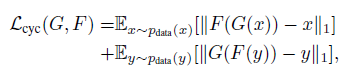
  
  
  
* Identity Loss : The identity mapping loss acts as an effective stabilizer
  at early stage of training. Without Lidentity, the generator G
  and F are free to change the tint of input images when there
  is no need to. The loss is calculated as 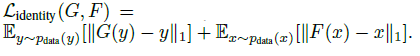
  
  
Total Loss for each generator is calculated as:

Adversarial Loss + (Lambda * Cycle Consistency Loss) + (0.5 * Lambda * Identity Loss)

where Lambda controls the relative importance of the loss functions. For the current implementation, we set Lambda = 10
  
**Training**

During training of the CycleGAN, we use GradientTape to update the weights of the generator models based on the calculated loss after combining the above 3 losses

In [12]:
class CycleGAN(Model):
    def __init__(
        self,
        ukiyo_generator,
        photo_generator,
        ukiyo_discriminator,
        photo_discriminator,
        lambda_cycle=10,
    ):
        super(CycleGAN, self).__init__()
        self.u_gen = ukiyo_generator
        self.p_gen = photo_generator
        self.u_disc = ukiyo_discriminator
        self.p_disc = photo_discriminator
        self.lambda_cycle = lambda_cycle
        
    def compile(
        self,
        u_gen_optimizer,
        p_gen_optimizer,
        u_disc_optimizer,
        p_disc_optimizer,
        gen_loss_fn,
        disc_loss_fn,
        cycle_loss_fn,
        identity_loss_fn
    ):
        super(CycleGAN, self).compile()
        self.u_gen_optimizer = u_gen_optimizer
        self.p_gen_optimizer = p_gen_optimizer
        self.u_disc_optimizer = u_disc_optimizer
        self.p_disc_optimizer = p_disc_optimizer
        self.gen_loss_fn = gen_loss_fn
        self.disc_loss_fn = disc_loss_fn
        self.cycle_loss_fn = cycle_loss_fn
        self.identity_loss_fn = identity_loss_fn
        
    def train_step(self, batch_data):
        real_ukiyo, real_photo = batch_data
        
        with tf.GradientTape(persistent=True) as tape:
            # Photo to ukiyo painting, and back to photo
            fake_ukiyo = self.u_gen(real_photo, training=True)
            cycled_photo = self.p_gen(fake_ukiyo, training=True)

            # Ukiyo painting to Photo and back to Ukiyo
            fake_photo = self.p_gen(real_ukiyo, training=True)
            cycled_ukiyo = self.u_gen(fake_photo, training=True)

            # Generate the same image. Required to calculate identity loss
            same_ukiyo = self.u_gen(real_ukiyo, training=True)
            same_photo = self.p_gen(real_photo, training=True)

            # discriminator to check real image
            disc_real_ukiyo = self.u_disc(real_ukiyo, training=True)
            disc_real_photo = self.p_disc(real_photo, training=True)

            # discriminator to check fake images
            disc_fake_ukiyo = self.u_disc(fake_ukiyo, training=True)
            disc_fake_photo = self.p_disc(fake_photo, training=True)

            # Calculate Generator Losses
            ukiyo_gen_loss = self.gen_loss_fn(disc_fake_ukiyo)
            photo_gen_loss = self.gen_loss_fn(disc_fake_photo)

            # Calculate Cycle Consistency Loss
            total_cycle_loss = self.cycle_loss_fn(real_ukiyo, cycled_ukiyo, self.lambda_cycle) + self.cycle_loss_fn(real_photo, cycled_photo, self.lambda_cycle)

            # Calculate Total Generator Loss
            total_ukiyo_gen_loss = ukiyo_gen_loss + total_cycle_loss + self.identity_loss_fn(real_ukiyo, same_ukiyo, self.lambda_cycle)
            total_photo_gen_loss = photo_gen_loss + total_cycle_loss + self.identity_loss_fn(real_photo, same_photo, self.lambda_cycle)

            # Calculate Discriminator Loss
            ukiyo_disc_loss = self.disc_loss_fn(disc_real_ukiyo, disc_fake_ukiyo)
            photo_disc_loss = self.disc_loss_fn(disc_real_photo, disc_fake_photo)

        # Calculate Gradients for Generator and Discriminator
        ukiyo_generator_gradients = tape.gradient(total_ukiyo_gen_loss,
                                                  self.u_gen.trainable_variables)
        photo_generator_gradients = tape.gradient(total_photo_gen_loss,
                                                  self.p_gen.trainable_variables)

        ukiyo_discriminator_gradients = tape.gradient(ukiyo_disc_loss,
                                                      self.u_disc.trainable_variables)
        photo_discriminator_gradients = tape.gradient(photo_disc_loss,
                                                      self.p_disc.trainable_variables)

        # Apply calculated gradients to the optimizer
        self.u_gen_optimizer.apply_gradients(zip(ukiyo_generator_gradients,
                                                 self.u_gen.trainable_variables))

        self.p_gen_optimizer.apply_gradients(zip(photo_generator_gradients,
                                                 self.p_gen.trainable_variables))

        self.u_disc_optimizer.apply_gradients(zip(ukiyo_discriminator_gradients,
                                                  self.u_disc.trainable_variables))

        self.p_disc_optimizer.apply_gradients(zip(photo_discriminator_gradients,
                                                  self.p_disc.trainable_variables))
        
        return {
            'ukiyo_gen_loss': total_ukiyo_gen_loss,
            'photo_gen_loss': total_photo_gen_loss,
            'ukiyo_disc_loss': ukiyo_disc_loss,
            'photo_disc_loss': photo_disc_loss
        }

Here we define the loss functions for Generatoe, Discriminator, Cycle Consistency and Identity

In [13]:
#Loss Functions

# Discriminator loss
def dis_loss(real, generated):
    real_loss = losses.BinaryCrossentropy(from_logits=True, reduction=losses.Reduction.NONE)(tf.ones_like(real), real)

    generated_loss = losses.BinaryCrossentropy(from_logits=True, reduction=losses.Reduction.NONE)(tf.zeros_like(generated), generated)

    total_disc_loss = real_loss + generated_loss

    return total_disc_loss * 0.5
    
# Generator loss
def gen_loss(generated):
    return losses.BinaryCrossentropy(from_logits=True, reduction=losses.Reduction.NONE)(tf.ones_like(generated), generated)
    
    
# Cycle consistency loss by calculating the mean difference between the real image and the cycled image
def cycle_loss(real_image, cycled_image, LAMBDA):
    loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))

    return LAMBDA * loss1

# Identity loss - To calculate the mean difference between the real image and the generator output with the same image

def id_loss(real_image, same_image, LAMBDA):
    loss = tf.reduce_mean(tf.abs(real_image - same_image))
    return LAMBDA * 0.5 * loss

In [15]:
n_ukiyo_samples = 562
n_photo_samples = 6287
ukiyo_gen = GENERATOR() # Real Photo to Ukiyo
real_gen = GENERATOR() # Ukiyo paintings to Real Photo

ukiyo_dis = DISCRIMINATOR() # Differentiate between Ukiyo and "Not Ukiyo: images
real_dis = DISCRIMINATOR() # Differentiate between Real and "Not Real" images
with strategy.scope():
    # Create generators
    ukiyo_generator_optimizer = optimizers.Adam(2e-4, beta_1=0.5)
    photo_generator_optimizer = optimizers.Adam(2e-4, beta_1=0.5)

    # Create discriminators
    ukiyo_discriminator_optimizer = optimizers.Adam(2e-4, beta_1=0.5)
    photo_discriminator_optimizer = optimizers.Adam(2e-4, beta_1=0.5)
    
    # Create GAN
    gan_model = CycleGAN(ukiyo_gen, real_gen, 
                         ukiyo_dis, real_dis)

    gan_model.compile(u_gen_optimizer=ukiyo_generator_optimizer,
                      p_gen_optimizer=photo_generator_optimizer,
                      u_disc_optimizer=ukiyo_discriminator_optimizer,
                      p_disc_optimizer=photo_discriminator_optimizer,
                      gen_loss_fn=gen_loss,
                      disc_loss_fn=dis_loss,
                      cycle_loss_fn=cycle_loss,
                      identity_loss_fn=id_loss)

    

model_history = gan_model.fit(zip_gan_dataset(UKIYO_TRAIN_FILES, REAL_TRAIN_FILES, batch_size=BATCH_SIZE), 
                        steps_per_epoch=(n_ukiyo_samples//BATCH_SIZE),
                        epochs=EPOCHS,
                        verbose=1).history

Found 562 files belonging to 1 classes.
Found 6287 files belonging to 1 classes.
Epoch 1/30
562/562 [==============================] - 268s 414ms/step - ukiyo_gen_loss: 3.8619 - photo_gen_loss: 3.7285 - ukiyo_disc_loss: 0.5446 - photo_disc_loss: 0.5803
Epoch 2/30
562/562 [==============================] - 234s 416ms/step - ukiyo_gen_loss: 3.1046 - photo_gen_loss: 3.0567 - ukiyo_disc_loss: 0.6060 - photo_disc_loss: 0.6045
Epoch 3/30
562/562 [==============================] - 234s 417ms/step - ukiyo_gen_loss: 3.1059 - photo_gen_loss: 3.0550 - ukiyo_disc_loss: 0.6224 - photo_disc_loss: 0.6051
Epoch 4/30
562/562 [==============================] - 234s 417ms/step - ukiyo_gen_loss: 3.0525 - photo_gen_loss: 2.9803 - ukiyo_disc_loss: 0.6171 - photo_disc_loss: 0.6088
Epoch 5/30
562/562 [==============================] - 234s 417ms/step - ukiyo_gen_loss: 3.0173 - photo_gen_loss: 2.9476 - ukiyo_disc_loss: 0.6094 - photo_disc_loss: 0.6095
Epoch 6/30
562/562 [==============================] - 235s 

In [45]:
ukiyo_gen.save('ukiyo_generator.h5')

# Final Output Generation

We generate the final output images using the test dataset, to see the results of Real Photo to Ukiyo drawing generator

In [17]:
#FUNCTION TO DISPLAY GENERATED OUTPUT SAMPLES
def display_generated_images(dataset, model, n_samples):
    ds_iter = iter(dataset)
    for n_sample in range(n_samples):
        example_sample = next(ds_iter)
        generated_sample = model.predict(example_sample)
        
        plt.subplot(121)
        plt.title("input image")
        plt.imshow(example_sample[0] * 0.5 + 0.5)
        plt.axis('off')
        
        plt.subplot(122)
        plt.title("Generated image")
        plt.imshow(generated_sample[0] * 0.5 + 0.5)
        plt.axis('off')
        plt.show()

Found 751 files belonging to 1 classes.
1/1 [==============================] - 0s 39ms/step


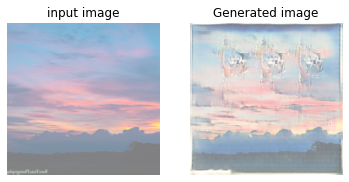

1/1 [==============================] - 0s 35ms/step


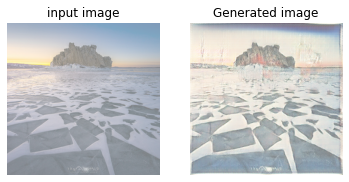

1/1 [==============================] - 0s 34ms/step


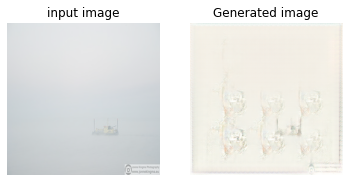

1/1 [==============================] - 0s 40ms/step


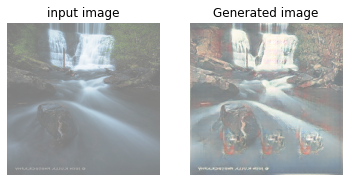

1/1 [==============================] - 0s 35ms/step


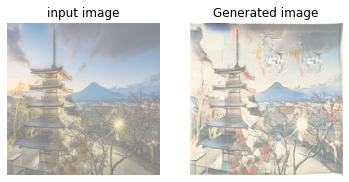

1/1 [==============================] - 0s 35ms/step


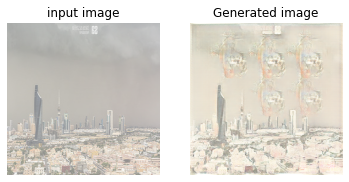

1/1 [==============================] - 0s 36ms/step


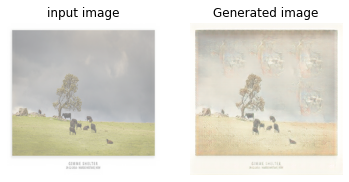

1/1 [==============================] - 0s 36ms/step


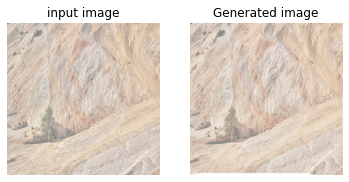

In [23]:
#VIEW REAL IMAGE -> UKIYO RESULTS
PHOTO_FILENAMES = r"C:\Users\adity\AI4 Project\ukiyoe2photo\testB"  #Load Test Dataset of Real Photos
display_generated_images(load_dataset(PHOTO_FILENAMES).batch(1), ukiyo_gen, 8)

Found 263 files belonging to 1 classes.
1/1 [==============================] - 0s 73ms/step


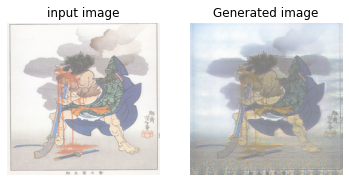

1/1 [==============================] - 0s 37ms/step


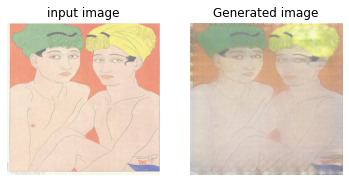

1/1 [==============================] - 1s 648ms/step


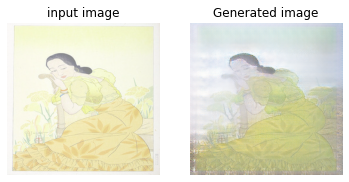

1/1 [==============================] - 0s 58ms/step


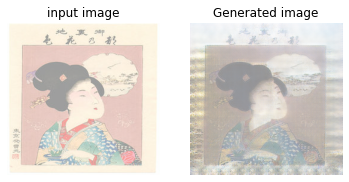

1/1 [==============================] - 0s 36ms/step


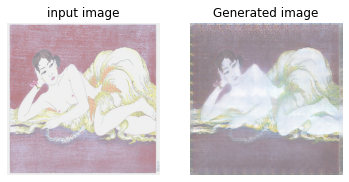

1/1 [==============================] - 0s 41ms/step


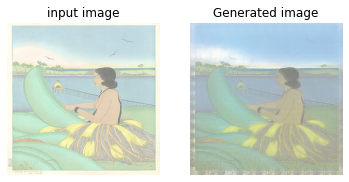

1/1 [==============================] - 0s 196ms/step


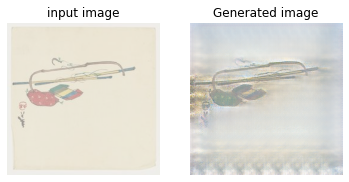

1/1 [==============================] - 0s 98ms/step


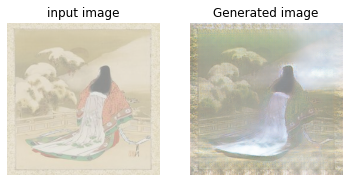

In [25]:
#VIEW UKIYO IMAGE -> REAL RESULTS
PHOTO_FILENAMES_REAL = r"C:\Users\adity\AI4 Project\ukiyoe2photo\testA"  #Load Test Dataset of Real Photos
display_generated_images(load_dataset(PHOTO_FILENAMES_REAL).batch(1), real_gen, 8)